# Concolutional Neural Network

## Importation librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv1D, Activation, MaxPooling1D, Flatten, Dense, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

import time

from sklearn.metrics import confusion_matrix
import seaborn as sns

import random

## Importation et affichage données

health: -1.0
[ 0.50205548  0.54216265  0.72238348  1.4288852   2.1365158   2.281149
  1.9362737   1.46889     1.0088451   0.38028224 -0.29677967 -0.51392868
 -0.25564469 -0.10720254 -0.28782655 -0.41800901 -0.31916313 -0.2603787
 -0.35035721 -0.50548599 -0.71088709 -0.82391982 -0.89970154 -1.1539497
 -1.2298306  -1.044091   -1.2020312  -1.3921949  -1.1301083  -1.1798666
 -1.6492718  -1.7265754  -1.6083704  -1.6628022  -1.6506724  -1.6973094
 -1.8386968  -1.8025962  -1.7805361  -1.8251665  -1.6447633  -1.4238097
 -1.3921949  -1.3604156  -1.2001781  -0.91863234 -0.68591581 -0.66794346
 -0.51272154 -0.10169069  0.06395426  0.08261431  0.23760718  0.17479318
  0.12320539  0.5033942   0.6838702   0.47499476  0.53279711  0.72354995
  0.6644198   0.64793559  0.75705403  0.7320716   0.62021499  0.60629677
  0.67795016  0.68908363  0.59880728  0.54264656  0.58180737  0.63063068
  0.6644198   0.6863178   0.65738251  0.65088944  0.72173837  0.73970645
  0.69148052  0.69522947  0.7501145   0.85384

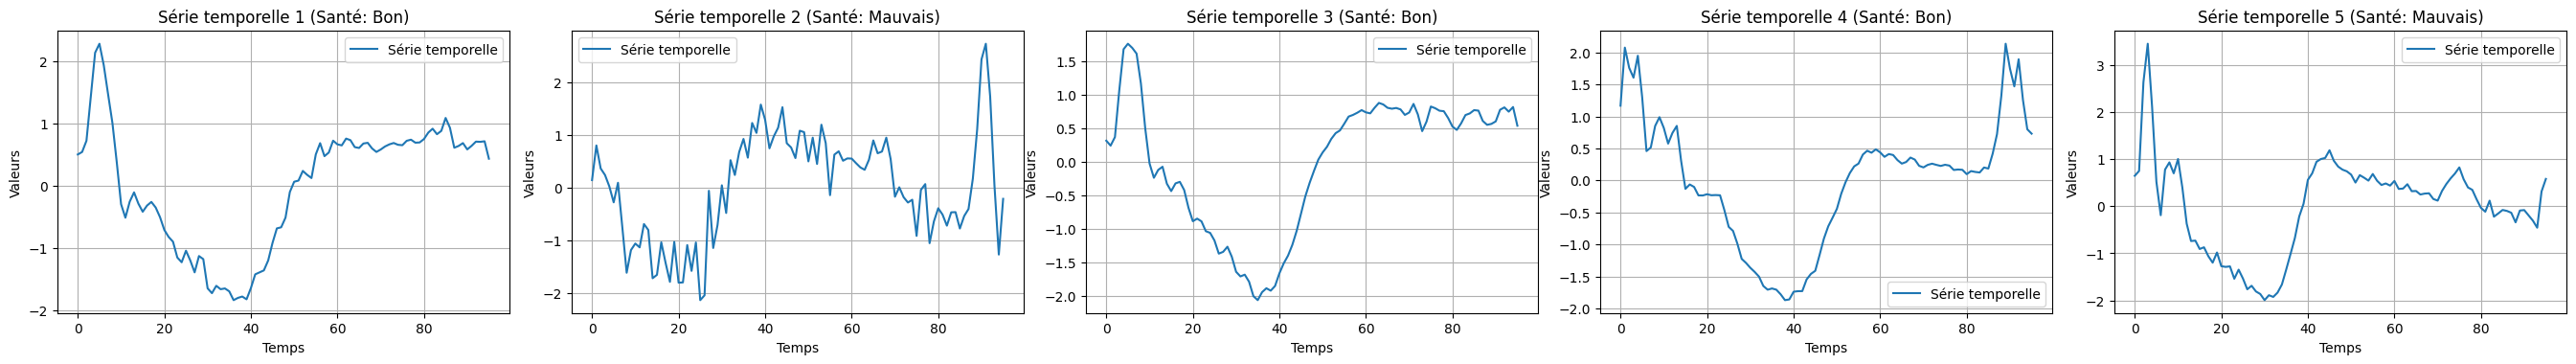

In [2]:
train_data = np.loadtxt('data/ECG200_TRAIN.tsv', delimiter='\t')
test_data = np.loadtxt('data/ECG200_TEST.tsv', delimiter='\t')

# Afficher la première série temporelle
print("health:", train_data[0,0])
print(train_data[0,1:])

# Afficher les dimensions des données
print("Dimensions des données d'entrainnement:", train_data.shape)
print("Dimensions des données de test:", test_data.shape)

# Afficher les 5 premières séries temporelles
nb_series_a_afficher = 5
plt.figure(figsize=(27, 7))
for i in range(nb_series_a_afficher):
    # Extraire la série temporelle et son état de santé correspondant
    serie_temporelle = train_data[i, 1:]
    etat_sante = train_data[i, 0]
    
    # Créer une plage de temps pour l'axe x
    plage_temps = range(len(serie_temporelle))
    
    # Placer la série temporelle dans le sous-graphique correspondant
    plt.subplot(2, nb_series_a_afficher, i+1)
    plt.plot(plage_temps, serie_temporelle, label='Série temporelle')
    plt.xlabel('Temps')
    plt.ylabel('Valeurs')
    plt.title(f'Série temporelle {i+1} (Santé: {"Bon" if etat_sante == -1 else "Mauvais"})')
    plt.legend()
    plt.grid(True)

# Ajuster automatiquement les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()



## Traitement données

In [3]:
# Normaliser les classe
train_data[train_data[:, 0] == -1, 0] = 0
test_data[test_data[:, 0] == -1, 0] = 0

# Séparation des données d'entrainnements et de tests
X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]

# Concaténer les données d'entraînement et de test pour trouver les valeurs maximales et minimales globales
all_data = np.concatenate((X_train, X_test), axis=0)
# Trouver les valeurs maximales et minimales globales
global_max = np.max(all_data)
global_min = np.min(all_data)
# Normaliser les séries temporelles entre 0 et 1 en utilisant les valeurs maximales et minimales globales
X_train_normalized = (X_train - global_min) / (global_max - global_min)
X_test_normalized = (X_test - global_min) / (global_max - global_min)

"""# Normaliser les série temporelle entre 0 et 1
X_train_normalized = tf.keras.utils.normalize(X_train, axis=1)
X_test_normalized = tf.keras.utils.normalize(X_test, axis=1)"""

# Convertir les étiquettes en encodage one-hot
y_train_encoded = to_categorical(y_train, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)

"""
print(X_train_normalized.shape)
print(X_train_normalized)
print(y_train_encoded.shape)
print(y_train_encoded)
"""


'\nprint(X_train_normalized.shape)\nprint(X_train_normalized)\nprint(y_train_encoded.shape)\nprint(y_train_encoded)\n'

## Choix des Hyperparamètres

❒ Les hyperparamètres des layers : kernel size, dropout, méthode d’activation des layers cachés, méthode d’activation du layer final, …

❒ Les hyperparamètres de compilation du modèle: optimizer, loss, learning rate …

❒ Les hyperparamètres d’exécution du modèle : batch size, nombre d’epochs, …

In [4]:
# HyperParameter des layers :
# specify filter numbers
filters = 1
# specify filter size
kernel_size = 3
# specify stride size
stride = 1
# 
padding = 'same'
# specify activation
activation = 'relu'
# specify pooling size
pool_size = 3
# taux de déconnexion
dropout_rate = 0.3
# number of classe
nb_classes = 2

# HyperParameter de compilation : 
# choose learning rate
learning_rate = 0.001
# choose the optimization algorithm by specifying the learning rate
optimizer_algo = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# choose the cost function: categorical cross entropy
cost_function = tf.keras.losses.categorical_crossentropy

## HyperParameter d’exécution : 
# choose batch size
mini_batch_size = 16
# choose number of epochs
nb_epochs = 200
# specify the percentage for validation
percentage_of_train_as_validation = 0.2

## Création du modèle

In [5]:
# input
input_shape = (96, 1)
input_layer = Input(input_shape)

# block
conv_layer_1_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding='same')(input_layer)
relu_layer_1_1 = Activation('relu')(conv_layer_1_1)
conv_layer_1_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding='same')(relu_layer_1_1)
relu_layer_1_2 = Activation('relu')(conv_layer_1_2)
pooling_layer_1 = MaxPooling1D(pool_size = pool_size, padding='same')(relu_layer_1_2)
dropout_layer_1_1 = Dropout(rate=dropout_rate)(relu_layer_1_1)

# output
flattened_layer = Flatten()(pooling_layer_1)
dropout_flattened = Dropout(rate=dropout_rate)(flattened_layer)
output_layer = Dense(units=nb_classes, activation='softmax')(dropout_flattened)

model = Model(inputs=input_layer, outputs=output_layer)

## Compilation du modèle

In [6]:
model.compile(loss=cost_function,optimizer=optimizer_algo, metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 1)          │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 1)          │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74 (296.00 B)

 Trainable params: 74 (296.00 B)

 Non-trainable params: 0 (0.00 B)

## Entrainnement du modèle

In [7]:
# specify the model checkpoint (to save the best model for each epoch)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best-model.keras', monitor='val_loss', save_best_only=True)
#model_checkpoint = model.save('my_model.keras')

# start training
history = model.fit(X_train_normalized, y_train_encoded, 
                    batch_size=mini_batch_size, 
                    epochs=nb_epochs,
                    validation_split=percentage_of_train_as_validation,
                    verbose=False,
                    callbacks=[model_checkpoint])


## Résultats du meilleur modèle

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.5673 - loss: 0.8838   
Test Loss: 0.8727763891220093
Test Accuracy: 0.5899999737739563


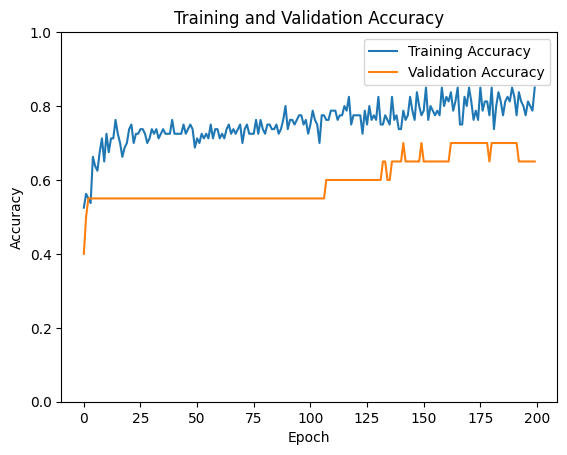

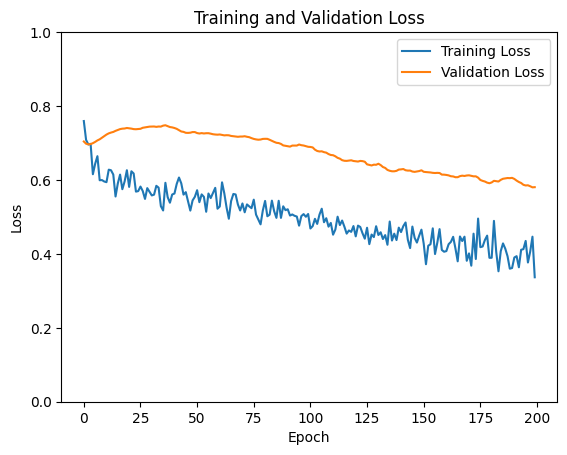

In [8]:

# Charge le meilleur modèle
best_model = tf.keras.models.load_model('best-model.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_train_normalized, y_test_encoded)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(0, 1)
plt.show()

## Matrice de confusion

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


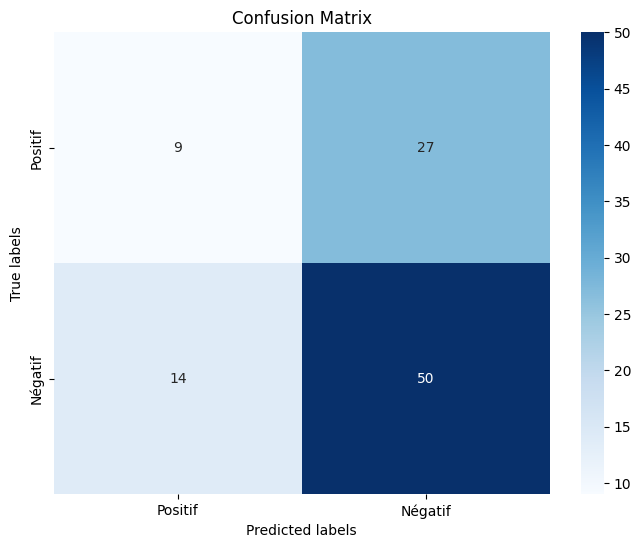

In [9]:
class_names = ['Positif', 'Négatif']

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_train_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)    

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [10]:

# HyperParameter :
filters = 5
kernel_size = 3
stride = 1
padding = 'same'
activation = 'relu'
pool_size = 3
dropout_rate = 0.3
nb_classes = 2 
learning_rate = 0.0005
optimizer_algo = tf.keras.optimizers.Adam(learning_rate=learning_rate)
cost_function = tf.keras.losses.categorical_crossentropy
mini_batch_size = 16
nb_epochs = 800
percentage_of_train_as_validation = 0.2

# Définir les plages de valeurs pour les hyperparamètres
filters_values = [3, 5, 10, 15]
kernel_size_values = [1, 2, 3, 5, 7]
strides_values = [1, 2, 3, 5]
pool_size_values = [1, 2, 3, 5]
dropout_rate_values = [0.1, 0.2, 0.3, 0.5, 0.7]
learning_rate_values = [0.001, 0.0001, 0.00001]
mini_batch_size_values = [8, 16, 32, 64]

# Nombre total de combinaisons à essayer
total_combinations = len(filters_values) * len(kernel_size_values) * len(strides_values) \
                   * len(pool_size_values) * len(dropout_rate_values) * len(learning_rate_values) \
                   * len(mini_batch_size_values)
print(total_combinations)
# Nombre de combinaisons à essayer
num_trials = 60

# Début du compteur de temps
start_time = time.time()

# Effectuer une recherche aléatoire
best_accuracy = 0
best_hyperparameters = None
for i in range(num_trials):
    print("epoch", i)
    # Sélectionner aléatoirement les valeurs des hyperparamètres
    filters = random.choice(filters_values)
    kernel_size = random.choice(kernel_size_values)
    stride = random.choice(strides_values)
    pool_size = random.choice(pool_size_values)
    dropout_rate =random.choice(dropout_rate_values)
    learning_rate = random.choice(learning_rate_values)
    mini_batch_size =random.choice(mini_batch_size_values)
    
    # Construire, compiler et entraîner le modèle avec ces hyperparamètres
    input_shape = (96, 1)
    input_layer = Input(input_shape)
    conv_layer_1_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding='same')(input_layer)
    relu_layer_1_1 = Activation('relu')(conv_layer_1_1)
    conv_layer_1_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding='same')(relu_layer_1_1)
    relu_layer_1_2 = Activation('relu')(conv_layer_1_2)
    pooling_layer_1 = MaxPooling1D(pool_size = pool_size, padding='same')(relu_layer_1_2)
    dropout_layer_1_1 = Dropout(rate=dropout_rate)(relu_layer_1_1)
    flattened_layer = Flatten()(pooling_layer_1)
    dropout_flattened = Dropout(rate=dropout_rate)(flattened_layer)
    output_layer = Dense(units=nb_classes, activation='softmax')(dropout_flattened)
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer_algo = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=cost_function,optimizer=optimizer_algo, metrics=['accuracy'])
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best-model.keras', monitor='val_loss', save_best_only=True)
    history = model.fit(X_train_normalized, y_train_encoded, 
                    batch_size=mini_batch_size, 
                    epochs=nb_epochs,
                    validation_split=percentage_of_train_as_validation,
                    verbose=True,
                    callbacks=[model_checkpoint])
    
    # Évaluer la performance du meilleur modèle
    best_model = tf.keras.models.load_model('best-model.keras')
    test_loss, test_accuracy = best_model.evaluate(X_train_normalized, y_test_encoded)
    
    # Mettre à jour les meilleurs hyperparamètres si nécessaire
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_loss = test_loss
        best_hyperparameters = (filters, kernel_size, stride, pool_size, dropout_rate, learning_rate, mini_batch_size)

# Fin du compteur de temps
end_time = time.time()

# Calcul de la durée d'entraînement en secondes
training_time_seconds = end_time - start_time

print("Meilleurs hyperparamètres :", best_hyperparameters)
print("Meilleure perte :", best_loss)
print("Meilleure précision :", best_accuracy)
print(f"Temps d'entraînement des hyperparamètre : {training_time_seconds // 60} minutes et {training_time_seconds % 60} secondes.")


19200
epoch 0
Epoch 1/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3601 - loss: 0.7064 - val_accuracy: 0.4500 - val_loss: 0.6951
Epoch 2/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2766 - loss: 0.7128 - val_accuracy: 0.4500 - val_loss: 0.6950
Epoch 3/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3283 - loss: 0.7117 - val_accuracy: 0.4500 - val_loss: 0.6949
Epoch 4/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3247 - loss: 0.7069 - val_accuracy: 0.4500 - val_loss: 0.6949
Epoch 5/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3597 - loss: 0.7020 - val_accuracy: 0.4500 - val_loss: 0.6948
Epoch 6/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2780 - loss: 0.7137 - val_accuracy: 0.4500 - val_loss: 0.6947
Epoch 7/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3550 - loss: 0.7070 - val_accuracy: 0.4500 - val_loss: 0.6947
Epoch 8/800
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3064 - loss: 0.7075 - val_accuracy: 0.45

In [11]:
"""# input
input_shape = (96, 1)
input_layer = Input(input_shape)

# block 1
conv_layer_1_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding='same')(input_layer)
relu_layer_1_1 = Activation('relu')(conv_layer_1_1)
conv_layer_1_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding='same')(relu_layer_1_1)
relu_layer_1_2 = Activation('relu')(conv_layer_1_2)
pooling_layer_1 = MaxPooling1D(pool_size = pool_size, padding='same')(relu_layer_1_2)
dropout_layer_1_1 = Dropout(rate=dropout_rate)(relu_layer_1_1)

# block 2
conv_layer_2_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding='same')(pooling_layer_1)
relu_layer_2_1 = Activation('relu')(conv_layer_2_1)
conv_layer_2_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding='same')(relu_layer_2_1)
relu_layer_2_2 = Activation('relu')(conv_layer_2_2)
pooling_layer_2 = MaxPooling1D(pool_size = pool_size, padding='same')(relu_layer_2_2)

# block 3
conv_layer_3_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding='same')(pooling_layer_2)
relu_layer_3_1 = Activation('relu')(conv_layer_3_1)
conv_layer_3_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding='same')(relu_layer_3_1)
relu_layer_3_2 = Activation('relu')(conv_layer_3_2)
pooling_layer_3 = MaxPooling1D(pool_size = pool_size, padding='same')(relu_layer_3_2)

# block 4
conv_layer_4_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding='same')(pooling_layer_3)
relu_layer_4_1 = Activation('relu')(conv_layer_4_1)
conv_layer_4_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding='same')(relu_layer_4_1)
relu_layer_4_2 = Activation('relu')(conv_layer_4_2)
pooling_layer_4 = MaxPooling1D(pool_size = pool_size, padding='same')(relu_layer_4_2)

# output
flattened_layer = Flatten()(pooling_layer_1)
dropout_flattened = Dropout(rate=dropout_rate)(flattened_layer)
output_layer = Dense(units=nb_classes, activation='softmax')(dropout_flattened)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss=cost_function,optimizer=optimizer_algo, metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

# specify the model checkpoint (to save the best model for each epoch)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best-model.h5', monitor='val_loss', save_best_only=True)

# Début du compteur de temps
start_time = time.time()

# start training
history = model.fit(X_train_normalized, y_train_encoded, 
                    batch_size=mini_batch_size, 
                    epochs=nb_epochs,
                    validation_split=percentage_of_train_as_validation,
                    verbose=False,
                    callbacks=[model_checkpoint])

# Fin du compteur de temps
end_time = time.time()

# Calcul de la durée d'entraînement en secondes
training_time_seconds = end_time - start_time

# Affichage de la durée d'entraînement en minutes et secondes
print(f"Temps d'entraînement : {training_time_seconds // 60} minutes et {training_time_seconds % 60} secondes.")

"""

'# input\ninput_shape = (96, 1)\ninput_layer = Input(input_shape)\n\n# block 1\nconv_layer_1_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=\'same\')(input_layer)\nrelu_layer_1_1 = Activation(\'relu\')(conv_layer_1_1)\nconv_layer_1_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=\'same\')(relu_layer_1_1)\nrelu_layer_1_2 = Activation(\'relu\')(conv_layer_1_2)\npooling_layer_1 = MaxPooling1D(pool_size = pool_size, padding=\'same\')(relu_layer_1_2)\ndropout_layer_1_1 = Dropout(rate=dropout_rate)(relu_layer_1_1)\n\n# block 2\nconv_layer_2_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=\'same\')(pooling_layer_1)\nrelu_layer_2_1 = Activation(\'relu\')(conv_layer_2_1)\nconv_layer_2_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=\'same\')(relu_layer_2_1)\nrelu_layer_2_2 = Activation(\'relu\')(conv_layer_2_2)\npooling_layer_2 = MaxPooling1D(pool_size = pool_size, padding=\'same\')(relu_lay